In [1]:
import ast
import os
import time
import yaml

import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm

from langchain_core.output_parsers import CommaSeparatedListOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from random import shuffle

from analysis import *

config_path = os.path.join("..", "config.yaml")
# Load the configuration file
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
    EMOTIONS, RANDOM_SEED = (
        config["EMOTIONS"],
        config["RANDOM_SEED"],
    )

# Loading Dataset

In [2]:
set_ = "train"
run_number = 3

In [3]:
dataset = load_dataset("go_emotions", "simplified")
dataset.set_format(type="pandas")
df = dataset[set_][:]
df = df.drop(columns=["id"])

int2label = lambda x: dataset[set_].features["labels"].feature.int2str(x)
df["labels_text"] = df["labels"].apply(int2label)

In [4]:
# samples = df[df["ds_emotions"].apply(lambda x: "neutral" in x)]
# samples = df.sample(200, random_state=RANDOM_SEED)
# take the second 500 examples
df = df[:1000]

# Define Model

In [21]:
output_parser = CommaSeparatedListOutputParser()
format_instructions = output_parser.get_format_instructions()

In [22]:
providers_api_base = {
    "ollama": "http://localhost:11434/v1",
    # models in https://fireworks.ai/models
    "fireworks": "https://api.fireworks.ai/inference/v1",
    # models in https://console.groq.com/docs/models
    "groq": "https://api.groq.com/openai/v1",
    # models in https://platform.openai.com/docs/models
    "openai": "https://api.openai.com/v1",
}

In [23]:
model_name = "accounts/fireworks/models/llama-v3p1-70b-instruct"
provider = "fireworks"
TEMPERATURE = 0.5

# Define models
chat = ChatOpenAI(
    temperature=TEMPERATURE,
    model_name=model_name,
    openai_api_base=providers_api_base[provider],
    openai_api_key=os.environ[provider],
)

# Labeling Functions

In [24]:
import asyncio
from concurrent.futures import ThreadPoolExecutor
from tqdm.asyncio import tqdm

In [25]:
def process_sample_sync(index, samples, EMOTIONS, format_instructions, chat):
    shuffle(EMOTIONS)
    SYSTEM_MESSAGE = f"""You're doing a classification task, given each text, think of the emotion it contains and of its context and try to classify it as one of these emotions {EMOTIONS}. IMPORTANT: rethink again! If there's no clear emotion, you must select 'neutral'.
    """

    PROMPT_TEMPLATE = f"""
    List outputs as {format_instructions}
    Input: {{comment}}
    """

    final_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", SYSTEM_MESSAGE),
            ("human", PROMPT_TEMPLATE),
        ]
    )
    chain = final_prompt | chat
    comment = samples.loc[index]["text"]
    response = chain.invoke(
        {"comment": comment}
    )  # Assuming chain.invoke is synchronous
    content = response.content
    input_tokens = response.response_metadata["token_usage"]["prompt_tokens"]
    output_tokens = response.response_metadata["token_usage"]["completion_tokens"]
    if content is None:
        print(f"Error in index {index}")
    samples.at[index, "predictions"] = content
    return input_tokens, output_tokens

In [26]:
async def generate_predictions(samples, EMOTIONS, format_instructions, chat):
    samples["predictions"] = None
    input_tokens = 0
    output_tokens = 0

    loop = asyncio.get_running_loop()

    with ThreadPoolExecutor() as pool:
        tasks = []
        for index in samples.index:
            try:
                task = loop.run_in_executor(
                    pool,
                    process_sample_sync,
                    index,
                    samples,
                    EMOTIONS,
                    format_instructions,
                    chat,
                )
                tasks.append(task)
            except Exception as e:
                print(f"Error processing sample at index {index}: {e}")
                return None, None, None  # Or any other appropriate return value

        results = await tqdm.gather(*tasks)

    for res in results:
        input_tokens += res[0]
        output_tokens += res[1]

    input_tokens = input_tokens / len(samples)
    output_tokens = output_tokens / len(samples)

    return samples, input_tokens, output_tokens

In [27]:
chunk_size = 500
samples = df.copy()
total_input_tokens = 0
total_output_tokens = 0
results_df = pd.DataFrame()  # Initialize an empty DataFrame to store results

total_chunks = (len(df) - 1) // chunk_size + 1  # Calculate total number of chunks

for i in range(total_chunks):
    start_index = i * chunk_size
    end_index = start_index + chunk_size
    chunk_indices = samples.index[start_index:end_index]
    chunk_samples, input_tokens, output_tokens = await generate_predictions(
        samples.loc[chunk_indices], EMOTIONS, format_instructions, chat
    )
    total_input_tokens += input_tokens
    total_output_tokens += output_tokens
    results_df = pd.concat([results_df, chunk_samples], ignore_index=True)

    # Sleep only if it's not the last iteration
    if i < total_chunks - 1:
        time.sleep(60)

print(f"Average input tokens: {total_input_tokens/len(df)}")
print(f"Average output tokens: {total_output_tokens/len(df)}")

100%|██████████| 500/500 [00:39<00:00, 12.56it/s]

prompt input tokens: 226.918
response output tokens: 3.948


# Labels Postprocessing

In [5]:
def clean_and_parse_predictions(predictions_series):
    result = pd.Series(
        [
            [p.strip() for p in prediction.split(",")]
            for prediction in predictions_series
        ]
    )
    # remove quotes (single, double if any)
    result = result.apply(
        lambda x: [
            item.replace("'", "").replace('"', "").replace("]", "").replace("[", "")
            for item in x
        ]
    )
    # remove and item contains any symbol except quotes
    result = result.apply(lambda x: [item.lower() for item in x if item.isalnum()])

    return result

In [6]:
results_df["predictions"] = clean_and_parse_predictions(results_df["predictions"])
results_df.to_csv(f"run{run_number}/{set_}_unfiltered.csv", index=False)

NameError: name 'results_df' is not defined

In [7]:
import ast


def filter_labels(x, emotions):
    removed = [label for label in x if label not in emotions]
    filtered_labels = [label for label in x if label in emotions]
    return filtered_labels, removed


def filter_predictions(
    path, EMOTIONS=EMOTIONS, fill_empty=False, save_removed_labels=False
):
    """
    Load the predictions from the CSV and filter them to only include the emotions in EMOTIONS
    """
    df = pd.read_csv(path)
    df["parsed_predictions"] = df["predictions"].apply(lambda x: ast.literal_eval(x))
    # Drop unnecessary columns
    df = df.drop(columns=["predictions", "labels_text"])

    # Apply filtering and accumulate removed labels
    removed_labels_list = []
    df["parsed_predictions"] = df["parsed_predictions"].apply(
        lambda x: filter_labels(x, EMOTIONS)
    )
    df["parsed_predictions"], removed_labels = zip(*df["parsed_predictions"])
    removed_labels_list.extend(
        [label for sublist in removed_labels for label in sublist]
    )

    # Count total number of removed labels
    removed_labels_count = len(removed_labels_list)
    print(f"Total number of removed labels: {removed_labels_count}")

    # Save removed labels to a CSV if specified
    if save_removed_labels:
        removed_labels_df = pd.DataFrame(
            removed_labels_list, columns=["Removed Labels"]
        )
        removed_labels_df.to_csv("CSVs/removed_labels.csv", index=False)
        print("Removed labels saved to 'CSVs/removed_labels.csv'.")

    # Remove duplicates
    df["parsed_predictions"] = df["parsed_predictions"].apply(lambda x: list(set(x)))

    # Fill empty predictions with "neutral"
    if fill_empty:
        empty_predictions = df[df["parsed_predictions"].apply(lambda x: len(x) == 0)]
        df["parsed_predictions"] = df["parsed_predictions"].apply(
            lambda x: ["neutral"] if len(x) == 0 else x
        )
        print(f"Number of empty predictions: {len(empty_predictions)}")

    # Create labels column
    df["labels"] = df["parsed_predictions"].apply(
        lambda x: [EMOTIONS.index(label) for label in x]
    )

    return df


def visualize_data(df, EMOTIONS=EMOTIONS, save=False):
    fig, axs = plt.subplots(1, 2, figsize=(13, 5), dpi=200)

    # Bar chart of label distribution
    label_counts = {}
    for labels in df["parsed_predictions"]:
        for label in labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1

    filtered_dict = {k: v for k, v in label_counts.items() if k in EMOTIONS}
    sorted_filtered_dict = {
        k: v for k, v in sorted(filtered_dict.items(), key=lambda item: item[1])
    }

    axs[0].barh(list(sorted_filtered_dict.keys()), list(sorted_filtered_dict.values()))
    axs[0].set_title("Label Distribution")

    # Histogram of number of labels per comment
    count = df["parsed_predictions"].apply(lambda x: len(x))
    axs[1].hist(count, bins=10)
    # Plot mean and median
    axs[1].axvline(
        count.mean(),
        color="k",
        linestyle="dashed",
        linewidth=1,
        label=f"Mean: {count.mean():.2f}",
    )
    axs[1].legend()
    axs[1].set_title("Number of Labels per Comment")

    plt.tight_layout()
    plt.show()

    print(f"Total number of labels counted: {sum(sorted_filtered_dict.values())}")
    print(f"Total number of labels in the dataset: {len(df)}")

    if save:
        fig.savefig(f"run{run_number}/{set_}_visualizations.png")

In [9]:
results_df_filtered = filter_predictions(
    f"run{run_number}/{set_}_unfiltered.csv", fill_empty=False, save_removed_labels=True
)

results_df_filtered.to_csv(f"run{run_number}/{set_}_filtered.csv", index=False)

Total number of removed labels: 63
Removed labels saved to 'CSVs/removed_labels.csv'.


# Visualizing Data

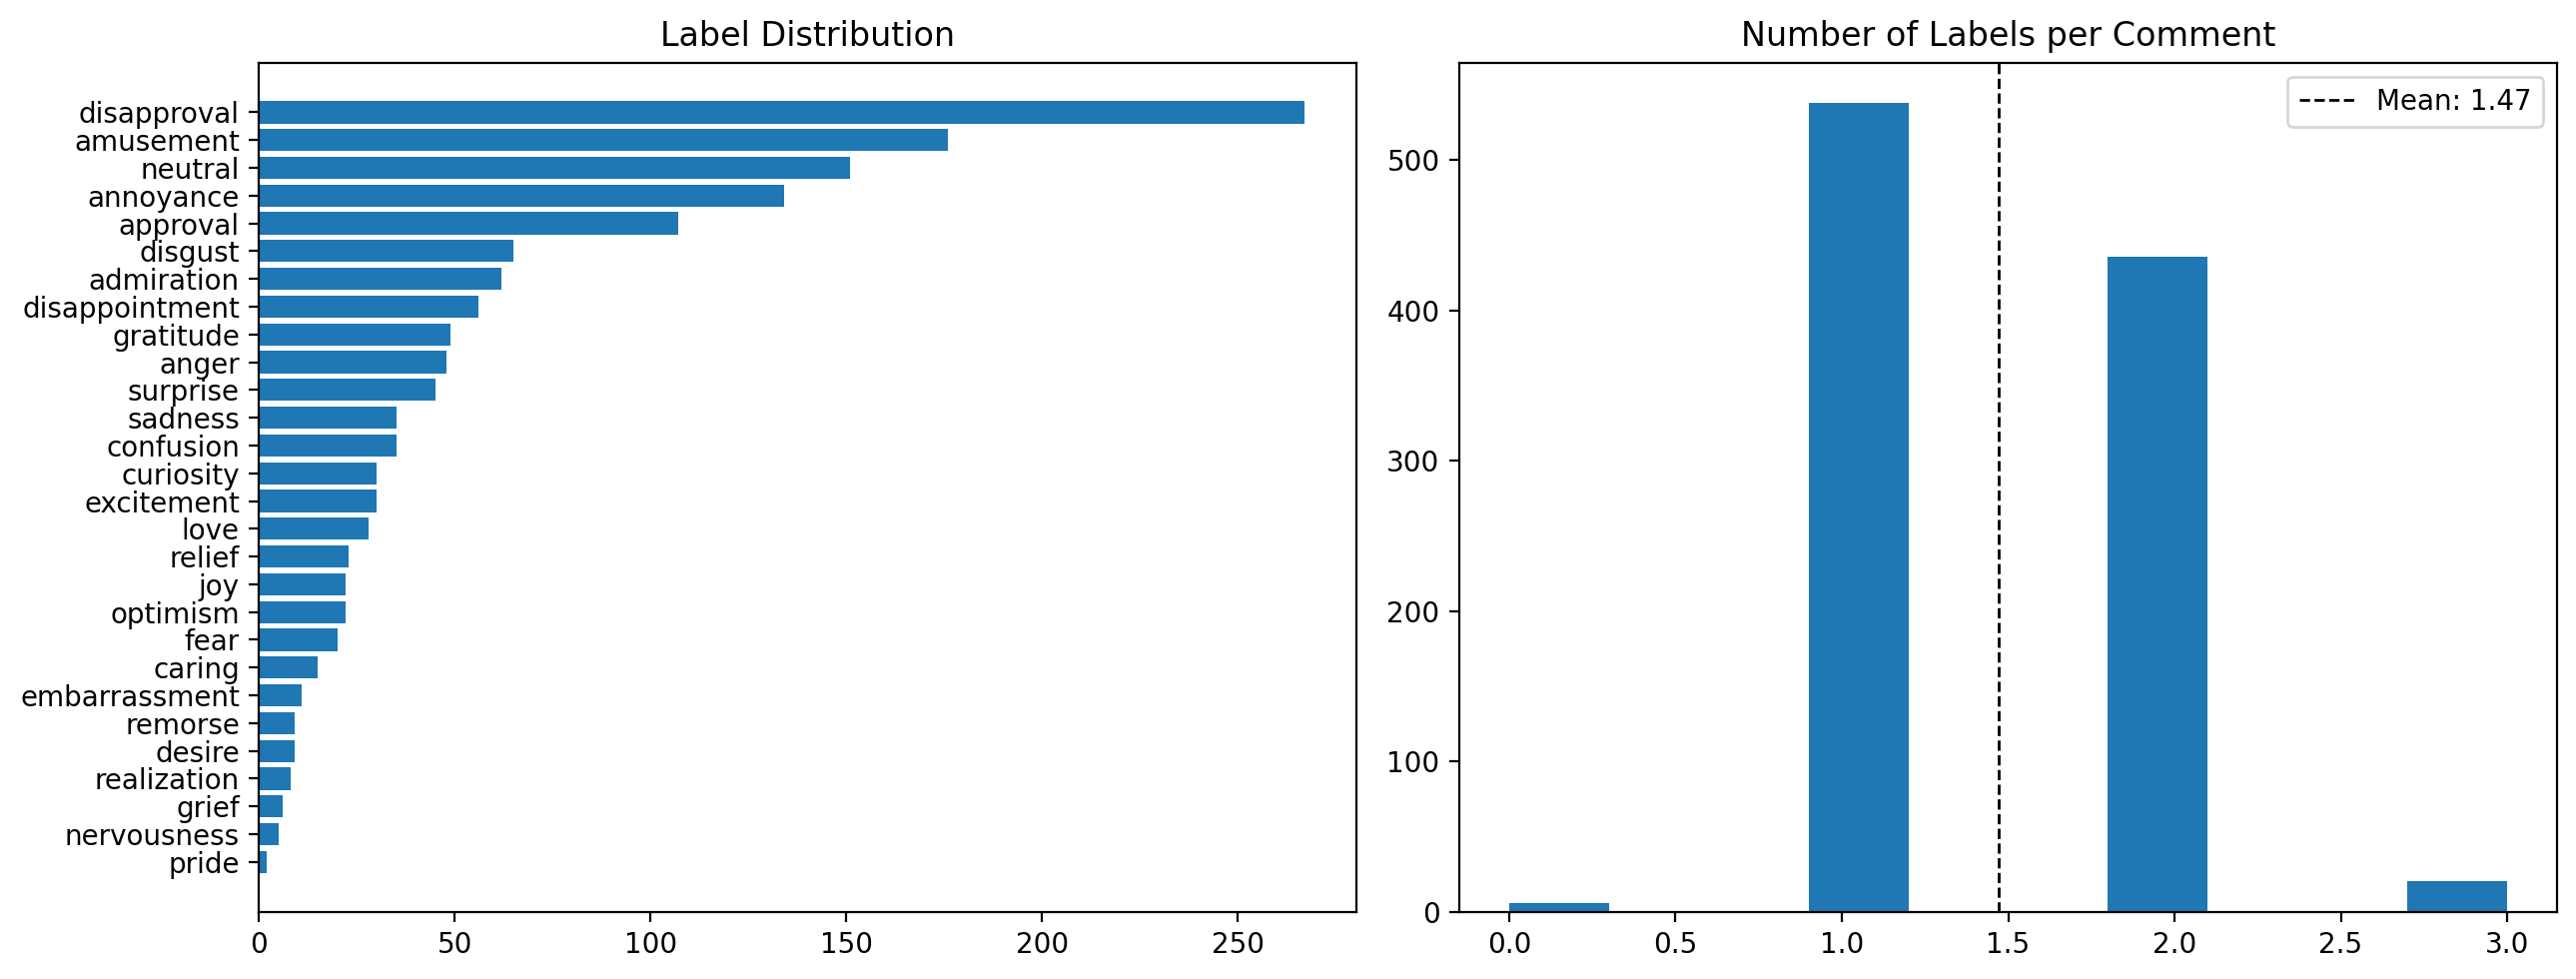

Total number of labels counted: 1470
Total number of labels in the dataset: 1000


In [10]:
visualize_data(results_df_filtered, save=False)

In [31]:
# get rows from results_df_filtered wheren parsed_predictions list has "neutral"
neutral_rows_3 = results_df_filtered[
    results_df_filtered["parsed_predictions"].apply(lambda x: "neutral" in x)
]
neutral_rows = results_df_filtered[df["labels_text"].apply(lambda x: "neutral" in x)]

In [34]:
# get rows in neutral_rows_3 but not in neutral_rows
ex_3 = neutral_rows_3[~neutral_rows_3.index.isin(neutral_rows.index)]
# join with df to get labels_text
ex_3 = ex_3.join(df["labels_text"], how="inner")

In [36]:
# save into ex_3.csv
ex_3.to_csv(f"run{run_number}/ex_3.csv", index=False)